<a href="https://colab.research.google.com/github/golfn123/CE888Project/blob/main/seq2seq/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import collections
 
import helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

In [ ]:
df = pd.read_json('https://raw.githubusercontent.com/golfn123/CE888Project/main/seq2seq/train_spider.json') #import dataset into dataframe
df.head

<bound method NDFrame.head of                       db_id  \
0     department_management   
1     department_management   
2     department_management   
3     department_management   
4     department_management   
...                     ...   
6995        culture_company   
6996        culture_company   
6997        culture_company   
6998        culture_company   
6999        culture_company   

                                                  query  \
0            SELECT count(*) FROM head WHERE age  >  56   
1     SELECT name ,  born_state ,  age FROM head ORD...   
2     SELECT creation ,  name ,  budget_in_billions ...   
3     SELECT max(budget_in_billions) ,  min(budget_i...   
4     SELECT avg(num_employees) FROM department WHER...   
...                                                 ...   
6995  SELECT T1.company_name FROM culture_company AS...   
6996  SELECT T1.title ,  T3.book_title FROM movie AS...   
6997  SELECT T1.title ,  T3.book_title FROM movie AS...   
6998  S

In [ ]:
#check is there any missing value in dataframe
df.isnull().values.any()
#the value shows that the dataset has no missing value.

False

In [ ]:
input = df['question']  #assign column question as input for learning model.
input

0       How many heads of the departments are older th...
1       List the name, born state and age of the heads...
2       List the creation year, name and budget of eac...
3       What are the maximum and minimum budget of the...
4       What is the average number of employees of the...
                              ...                        
6995    What are all the company names that have a boo...
6996    Show the movie titles and book titles for all ...
6997    What are the titles of movies and books corres...
6998    Show all company names with a movie directed i...
6999    What are all company names that have a corresp...
Name: question, Length: 7000, dtype: object

In [ ]:
input_selected = []     #select the first 1000 input for creating the translation model.
for i in range(999):
  input_selected.append(input[i])
input_selected

['How many heads of the departments are older than 56 ?',
 'List the name, born state and age of the heads of departments ordered by age.',
 'List the creation year, name and budget of each department.',
 'What are the maximum and minimum budget of the departments?',
 'What is the average number of employees of the departments whose rank is between 10 and 15?',
 'What are the names of the heads who are born outside the California state?',
 "What are the distinct creation years of the departments managed by a secretary born in state 'Alabama'?",
 'What are the names of the states where at least 3 heads were born?',
 'In which year were most departments established?',
 "Show the name and number of employees for the departments managed by heads whose temporary acting value is 'Yes'?",
 'How many acting statuses are there?',
 'How many departments are led by heads who are not mentioned?',
 'What are the distinct ages of the heads who are acting?',
 "List the states where both the secretary

In [ ]:
output = df['query'] #assign output from sql column
output

0              SELECT count(*) FROM head WHERE age  >  56
1       SELECT name ,  born_state ,  age FROM head ORD...
2       SELECT creation ,  name ,  budget_in_billions ...
3       SELECT max(budget_in_billions) ,  min(budget_i...
4       SELECT avg(num_employees) FROM department WHER...
                              ...                        
6995    SELECT T1.company_name FROM culture_company AS...
6996    SELECT T1.title ,  T3.book_title FROM movie AS...
6997    SELECT T1.title ,  T3.book_title FROM movie AS...
6998    SELECT T2.company_name FROM movie AS T1 JOIN c...
6999    SELECT T2.company_name FROM movie AS T1 JOIN c...
Name: query, Length: 7000, dtype: object

In [ ]:
output_selected = []  #select the first 1000 output for creating the translation model.
for i in range(999):
  output_selected.append(output[i])
output_selected

['SELECT count(*) FROM head WHERE age  >  56',
 'SELECT name ,  born_state ,  age FROM head ORDER BY age',
 'SELECT creation ,  name ,  budget_in_billions FROM department',
 'SELECT max(budget_in_billions) ,  min(budget_in_billions) FROM department',
 'SELECT avg(num_employees) FROM department WHERE ranking BETWEEN 10 AND 15',
 "SELECT name FROM head WHERE born_state != 'California'",
 "SELECT DISTINCT T1.creation FROM department AS T1 JOIN management AS T2 ON T1.department_id  =  T2.department_id JOIN head AS T3 ON T2.head_id  =  T3.head_id WHERE T3.born_state  =  'Alabama'",
 'SELECT born_state FROM head GROUP BY born_state HAVING count(*)  >=  3',
 'SELECT creation FROM department GROUP BY creation ORDER BY count(*) DESC LIMIT 1',
 "SELECT T1.name ,  T1.num_employees FROM department AS T1 JOIN management AS T2 ON T1.department_id  =  T2.department_id WHERE T2.temporary_acting  =  'Yes'",
 'SELECT count(DISTINCT temporary_acting) FROM management',
 'SELECT count(*) FROM department WH

In [ ]:
df.columns #shows columns in in spider.json file

Index(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question',
       'question_toks', 'sql'],
      dtype='object')

In [ ]:
import collections
questions_words_counter = collections.Counter([word for sentence in input_selected for word in sentence.split()])
queries_words_counter = collections.Counter([word for sentence in output_selected for word in sentence.split()])

print('In the training data set')
print('{} words in questions.'.format(len([word for sentence in input_selected for word in sentence.split()])))
print('{} unique words.'.format(len(questions_words_counter)))
print('10 Most common words in the questions dataset:')
print('"' + '" "'.join(list(zip(*questions_words_counter.most_common(10)))[0]) + '"')
print()
print('{} in SQL queries.'.format(len([word for sentence in output_selected for word in sentence.split()])))
print('{} unique words.'.format(len(queries_words_counter)))
print('10 Most common words in the SQL queries dataset:')
print('"' + '" "'.join(list(zip(*queries_words_counter.most_common(10)))[0]) + '"')

In the training data set
12198 words in questions.
1437 unique words.
10 Most common words in the questions dataset:
"the" "of" "What" "and" "are" "is" "all" "names" "that" "name"

14606 in SQL queries.
937 unique words.
10 Most common words in the SQL queries dataset:
"FROM" "SELECT" "=" "AS" "WHERE" "BY" "," "JOIN" "ON" "T1"


In [ ]:
#Tokenization
def tokenize(x):
  """
  Tokenize x
  :param x: List of sentences/strings to be tokenized
  :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
  """
  # TODO: Implement
  x_tk = Tokenizer()
  x_tk.fit_on_texts(x)

  return x_tk.texts_to_sequences(x), x_tk

#Padding
def pad(x, length=None):
  """
  Pad x
  :param x: List of sequences.
  :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
  :return: Padded numpy array of sequences
  """
  # TODO: Implement
  if length is None:
    length = max([len(sentence) for sentence in x])
  return pad_sequences(x, maxlen=length, padding='post', truncating='post')

def preprocess(x, y):
  """
  Preprocess x and y
  :param x: Feature List of sentences
  :param y: Label List of sentences
  :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
  """
  preprocess_x, x_tk = tokenize(x)
  preprocess_y, y_tk = tokenize(y)

  preprocess_x = pad(preprocess_x)
  preprocess_y = pad(preprocess_y)

  # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
  preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

  return preprocess_x, preprocess_y, x_tk, y_tk

#Create a function to convert word ID to text
def logits_to_text(logits, tokenizer):
  """
  Turn logits from a neural network into text using the tokenizer
  :param logits: Logits from a neural network
  :param tokenizer: Keras Tokenizer fit on the labels
  :return: String that represents the text of the logits
  """
  index_to_words = {id: word for word, id in tokenizer.word_index.items()}
  index_to_words[0] = '<PAD>'

  return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [ ]:
preprocess_x, preprocess_y, x_tk, y_tk = preprocess(input_selected, output_selected)

x_sequence_length = preprocess_x.shape[1]
y_sequence_length = preprocess_y.shape[1]
x_vocab_size = len(x_tk.word_index)
y_vocab_size = len(y_tk.word_index)


print("Max question sentence length:", x_sequence_length)
print("Max SQL sentence length:", y_sequence_length)
print("Question vocabulary size:", x_vocab_size)
print("SQL vocabulary size:", y_vocab_size)

Max question sentence length: 26
Max SQL sentence length: 81
Question vocabulary size: 914
SQL vocabulary size: 541


In [ ]:
#Split data 70% for training, 15% validation, 15% test
x_train, x_test, y_train, y_test = train_test_split(preprocess_x, preprocess_y, test_size=0.3, random_state=22)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=22)

print(len(x_train), 'train sequences', x_train.shape)
print(len(x_val), 'validation sequences', x_val.shape)
print(len(x_test), 'test sequences', x_test.shape)

699 train sequences (699, 26)
150 validation sequences (150, 26)
150 test sequences (150, 26)


In [ ]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
 
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 81, 1)]           0         
                                                                 
 gru (GRU)                   (None, 81)                20412     
                                                                 
 dense (Dense)               (None, 128)               10496     
                                                                 
 repeat_vector (RepeatVector  (None, 81, 128)          0         
 )                                                               
                                                                 
 gru_1 (GRU)                 (None, 81, 128)           99072     
                                                                 
 time_distributed (TimeDistr  (None, 81, 542)          69918     
 ibuted)                                                     

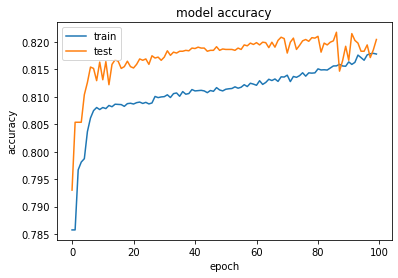

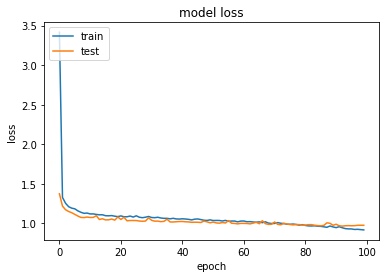

In [ ]:
from keras.layers import RepeatVector
def encdec_model(input_shape, output_sequence_length, input_vocab_size, output_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param input_vocab_size: Number of unique  words in input the dataset
    :param output_vocab_size: Number of unique words in output the dataset
    :return: Keras model built, but not trained
    #don't forget to change these
    """
    learning_rate = 0.001
    model = Sequential()
    #Encoder
    inputs = Input(shape=input_shape[1:])
    gru = GRU(output_sequence_length)(inputs)
    e_out = Dense(128, activation='relu')(gru) #old 128
    #Decoder
    d_input = RepeatVector(output_sequence_length)(e_out)
    d_gru = GRU(128, return_sequences=True)(d_input) #old 128
    layer = TimeDistributed(Dense(output_vocab_size, activation='softmax'))
    final = layer(d_gru)
    #Create Model from parameters defined above
    model = Model(inputs=inputs, outputs=final)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
     
     
    return model
     

# Train and Print prediction(s)
tmp_x = pad(x_train, y_train.shape[1])
tmp_x = tmp_x.reshape((-1, y_train.shape[-2], 1))
x_val_processed = pad(x_val, y_val.shape[1])
x_val_processed = x_val_processed.reshape((-1, y_val.shape[-2], 1)) 
# Train and Print prediction(s)
ed_rnn_model = encdec_model(
    tmp_x.shape,
    y_train.shape[1],
    len(x_tk.word_index)+1,
    len(y_tk.word_index)+1)
ed_rnn_model.summary()
 
history =ed_rnn_model.fit(tmp_x, y_train, batch_size=20, epochs=100, validation_data=(x_val_processed, y_val))
print(history.history.keys())
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#print out the performance of Encoder-Decoder model
print('avg accuracy =', np.average(history.history['accuracy']))
print('avg loss = ', np.average(history.history['loss']))
print('avg validation accuracy =', np.average(history.history['val_accuracy']))
print('avg validation loss =', np.average(history.history['val_loss']))

avg accuracy = 0.810996663570404
avg loss =  1.0647461855411529
avg validation accuracy = 0.8174609029293061
avg validation loss = 1.0246789342164992


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 81, 256)          100608    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 81, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 81, 256)          296448    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 81, 256)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 81, 256)          65792     
 tributed)                                                       
                                                      

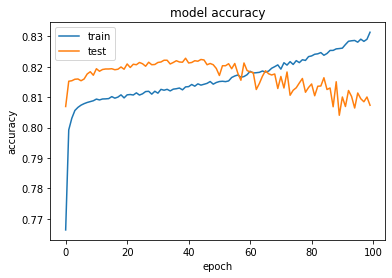

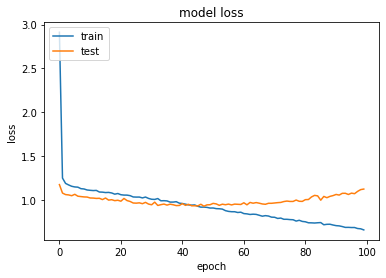

In [ ]:
#Bidirectional RNN
#Can change dropout rate to see the performance of the models with different parameters
#Add early stopping criteria
from keras.layers import Bidirectional
from keras.layers import Dropout
def bd_model(input_shape, output_sequence_length, input_vocab_size, output_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param input_vocab_size: Number of unique input words in the dataset
    :param output_vocab_size: Number of unique output words in the dataset
    :return: Keras model built, but not trained
    """
     
    learning_rate = 0.001
    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape[1:]))
    model.add(Dropout(0.5))
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(output_vocab_size, activation='softmax'))) 
     
     
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
     
     
    return model
 
callback_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) #set up early stop criteria
# Train and Print prediction(s)
tmp_x = pad(x_train, y_train.shape[1])
tmp_x = tmp_x.reshape((-1, y_train.shape[-2], 1))
x_val_processed = pad(x_val, y_val.shape[1])
x_val_processed = x_val_processed.reshape((-1, y_val.shape[-2], 1))
 
# Train and Print prediction(s)
bd_rnn_model = bd_model(tmp_x.shape, y_train.shape[1], x_vocab_size+1, y_vocab_size+1)
bd_rnn_model.summary()

history_bd = bd_rnn_model.fit(tmp_x, y_train, batch_size=20, epochs=100, validation_data=(x_val_processed, y_val),callbacks=[callback_loss])
print(history_bd.history.keys())
print(history_bd.history.keys())
# summarize history for accuracy
plt.plot(history_bd.history['accuracy'])
plt.plot(history_bd.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_bd.history['loss'])
plt.plot(history_bd.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print('avg accuracy =', np.average(history_bd.history['accuracy']))
print('avg loss = ', np.average(history_bd.history['loss']))
print('avg validation accuracy =', np.average(history_bd.history['val_accuracy']))
print('avg validation loss =', np.average(history_bd.history['val_loss']))


avg accuracy = 0.8159525954723358
avg loss =  0.9292942553758621
avg validation accuracy = 0.8169259244203567
avg validation loss = 0.9944893664121628


In [ ]:
#Tranlation from Encoder-Decoder model 1.
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
y_id_to_word[0] = '<PAD>'

sentence = 'how many heads of the departments are older than 56'
sentence = [x_tk.word_index[word] for word in sentence.split()]
sentence = pad_sequences([sentence], maxlen=x_train.shape[-1], padding='post')
sentences = np.array([sentence[0], x_train[0]])
tmp_x = pad(sentences, y_train.shape[1])
tmp_x = tmp_x.reshape((-1, y_train.shape[-2], 1))
predictions = ed_rnn_model.predict(tmp_x, len(tmp_x))
print('Sample 1 Padded:',sentence)
print('Actual Query:', output_selected[0] )
print('Output Query from Encoder-Decoder model:')
print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))

Sample 1 Padded: [[ 16  17 212   2   1 213   5 297  21 703   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
Actual Query: SELECT count(*) FROM head WHERE age  >  56
Output Query from Encoder-Decoder model:
select count from from where where by <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [ ]:
#Translation from Bidirectional Model 1
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
y_id_to_word[0] = '<PAD>'

sentence = 'how many heads of the departments are older than 56'
sentence = [x_tk.word_index[word] for word in sentence.split()]
sentence = pad_sequences([sentence], maxlen=x_train.shape[-1], padding='post')
sentences = np.array([sentence[0], x_train[0]])
tmp_x = pad(sentences, y_train.shape[1])
tmp_x = tmp_x.reshape((-1, y_train.shape[-2], 1))
predictions = bd_rnn_model.predict(tmp_x, len(tmp_x))
print('Sample 1 padded:',sentence)
print('Actual Query:', output_selected[0] )
print('Output Query From Bidirectional model:')
print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))

Sample 1 padded: [[ 16  17 212   2   1 213   5 297  21 703   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
Actual Query: SELECT count(*) FROM head WHERE age  >  56
Output Query From Bidirectional model:
select count from from where where 56 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 81, 1)]           0         
                                                                 
 gru_8 (GRU)                 (None, 81)                20412     
                                                                 
 dense_8 (Dense)             (None, 256)               20992     
                                                                 
 repeat_vector_2 (RepeatVect  (None, 81, 256)          0         
 or)                                                             
                                                                 
 gru_9 (GRU)                 (None, 81, 256)           394752    
                                                                 
 time_distributed_6 (TimeDis  (None, 81, 542)          139294    
 tributed)                                                 

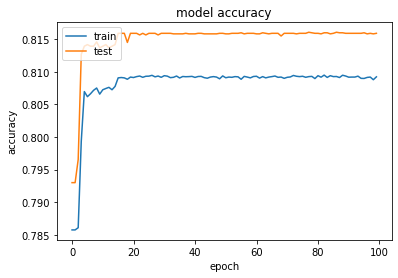

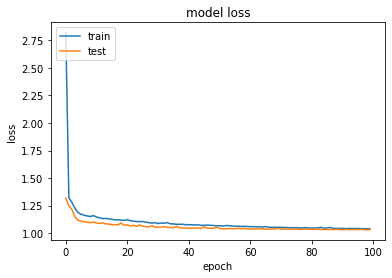

In [26]:
# changing parameter for Encoder-Decoder model
from keras.layers import RepeatVector
def encdec_model(input_shape, output_sequence_length, input_vocab_size, output_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param input_vocab_size: Number of unique  words in input the dataset
    :param output_vocab_size: Number of unique words in output the dataset
    :return: Keras model built, but not trained
    #don't forget to change these
    """
    learning_rate = 0.001
    model = Sequential()
    #Encoder
    inputs = Input(shape=input_shape[1:])
    gru = GRU(output_sequence_length)(inputs)
    e_out = Dense(256, activation='relu')(gru) #old 128
    #Decoder
    d_input = RepeatVector(output_sequence_length)(e_out)
    d_gru = GRU(256, return_sequences=True)(d_input) #old 128
    layer = TimeDistributed(Dense(output_vocab_size, activation='softmax'))
    final = layer(d_gru)
    #Create Model from parameters defined above
    model = Model(inputs=inputs, outputs=final)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
     
     
    return model
     

# Train and Print prediction(s)
tmp_x = pad(x_train, y_train.shape[1])
tmp_x = tmp_x.reshape((-1, y_train.shape[-2], 1))
x_val_processed = pad(x_val, y_val.shape[1])
x_val_processed = x_val_processed.reshape((-1, y_val.shape[-2], 1)) 
# Train and Print prediction(s)
ed_rnn_model_2 = encdec_model(
    tmp_x.shape,
    y_train.shape[1],
    len(x_tk.word_index)+1,
    len(y_tk.word_index)+1)
ed_rnn_model_2.summary()
 
history_ed2 =ed_rnn_model_2.fit(tmp_x, y_train, batch_size=20, epochs=100, validation_data=(x_val_processed, y_val))
print(history_ed2.history.keys())
print(history_ed2.history.keys())
# summarize history for accuracy
plt.plot(history_ed2.history['accuracy'])
plt.plot(history_ed2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_ed2.history['loss'])
plt.plot(history_ed2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#print out the performance of Encoder-Decoder model
print('avg accuracy =', np.average(history_ed2.history['accuracy']))
print('avg loss = ', np.average(history_ed2.history['loss']))
print('avg validation accuracy =', np.average(history_ed2.history['val_accuracy']))
print('avg validation loss =', np.average(history_ed2.history['val_loss']))

avg accuracy = 0.8081788814067841
avg loss =  1.0962850451469421
avg validation accuracy = 0.8149695414304733
avg validation loss = 1.0571299386024475


In [28]:
#Tranlation from Encoder-Decoder model 2.
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
y_id_to_word[0] = '<PAD>'

sentence = 'how many heads of the departments are older than 56'
sentence = [x_tk.word_index[word] for word in sentence.split()]
sentence = pad_sequences([sentence], maxlen=x_train.shape[-1], padding='post')
sentences = np.array([sentence[0], x_train[0]])
tmp_x = pad(sentences, y_train.shape[1])
tmp_x = tmp_x.reshape((-1, y_train.shape[-2], 1))
predictions = ed_rnn_model_2.predict(tmp_x, len(tmp_x))
print('Sample 1 Padded:',sentence)
print('Actual Query:', output_selected[0] )
print('Output Query from Encoder-Decoder model:')
print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))

Sample 1 Padded: [[ 16  17 212   2   1 213   5 297  21 703   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
Actual Query: SELECT count(*) FROM head WHERE age  >  56
Output Query from Encoder-Decoder model:
select count from from from from <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 81, 512)          397824    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 81, 512)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 81, 512)          1182720   
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 81, 512)           0         
                                                                 
 time_distributed_9 (TimeDis  (None, 81, 512)          262656    
 tributed)                                                       
                                                      

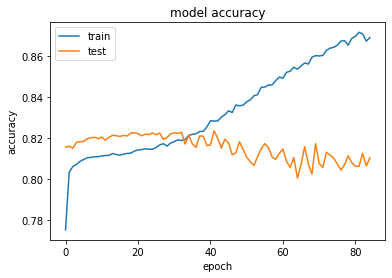

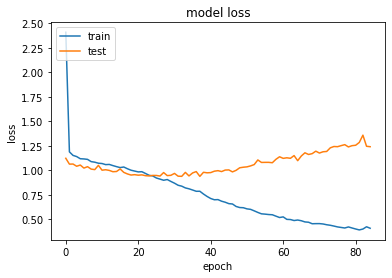

In [33]:
#Bidirectional RNN
#Change parameters to observe the changes in performance
#Add early stopping criteria
from keras.layers import Bidirectional
from keras.layers import Dropout
def bd_model(input_shape, output_sequence_length, input_vocab_size, output_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param input_vocab_size: Number of unique input words in the dataset
    :param output_vocab_size: Number of unique output words in the dataset
    :return: Keras model built, but not trained
    """
     
    learning_rate = 0.001
    model = Sequential()
    model.add(Bidirectional(GRU(256, return_sequences=True), input_shape=input_shape[1:]))
    model.add(Dropout(0.4))
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(output_vocab_size, activation='softmax'))) 
     
     
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
     
     
    return model
 
callback_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) #set up early stop criteria
# Train and Print prediction(s)
tmp_x = pad(x_train, y_train.shape[1])
tmp_x = tmp_x.reshape((-1, y_train.shape[-2], 1))
x_val_processed = pad(x_val, y_val.shape[1])
x_val_processed = x_val_processed.reshape((-1, y_val.shape[-2], 1))
 
# Train and Print prediction(s)
bd_rnn_model_2 = bd_model(tmp_x.shape, y_train.shape[1], x_vocab_size+1, y_vocab_size+1)
bd_rnn_model_2.summary()

history_bd_2 = bd_rnn_model_2.fit(tmp_x, y_train, batch_size=20, epochs=100, validation_data=(x_val_processed, y_val),callbacks=[callback_loss])
print(history_bd_2.history.keys())
print(history_bd_2.history.keys())
# summarize history for accuracy
plt.plot(history_bd_2.history['accuracy'])
plt.plot(history_bd_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_bd_2.history['loss'])
plt.plot(history_bd_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
#print out the performance of Bidirectional model
print('avg accuracy =', np.average(history_bd_2.history['accuracy']))
print('avg loss = ', np.average(history_bd_2.history['loss']))
print('avg validation accuracy =', np.average(history_bd_2.history['val_accuracy']))
print('avg validation loss =', np.average(history_bd_2.history['val_loss']))

avg accuracy = 0.8379486165940762
avg loss =  0.5824611447751522
avg validation accuracy = 0.8055143989622593
avg validation loss = 1.2259988114237785


In [32]:
#Tranlation from Bidirectional model 2.
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
y_id_to_word[0] = '<PAD>'

sentence = 'how many heads of the departments are older than 56'
sentence = [x_tk.word_index[word] for word in sentence.split()]
sentence = pad_sequences([sentence], maxlen=x_train.shape[-1], padding='post')
sentences = np.array([sentence[0], x_train[0]])
tmp_x = pad(sentences, y_train.shape[1])
tmp_x = tmp_x.reshape((-1, y_train.shape[-2], 1))
predictions = bd_rnn_model_2.predict(tmp_x, len(tmp_x))
print('Sample 1 Padded:',sentence)
print('Actual Query:', output_selected[0] )
print('Output Query from Encoder-Decoder model:')
print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))

Sample 1 Padded: [[ 16  17 212   2   1 213   5 297  21 703   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
Actual Query: SELECT count(*) FROM head WHERE age  >  56
Output Query from Encoder-Decoder model:
publication catalog catalog catalog catalog catalog catalog catalog catalog catalog 'ala percent percent percent percent percent percent percent order 99 99 99 99 99 rep rep rep rep bikes bikes bikes bikes bikes bikes bikes bikes bikes bikes bikes bikes bikes bikes bikes level level max id id <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
